# AIRLINES ON-TIME PERFORMANCES FOR YEAR 2007

## INTRODUCTION

Timing is everything, especially at the airport. Whether it is rush-hour skies or stormy seasons, certain moments are more prone to flight delays. Let’s uncover when you are most likely to be left waiting at the departure gate.

## About Dataset

The dataset used comes from the 2009 ASA Statistical Computing and Graphics Data Expo and contains detailed records of all commercial flight arrivals and departures by major U.S. carriers for the year 2007. It includes comprehensive information on flight schedules, delays, cancellations, and other performance metrics. The data was obtained from Kaggle:
https://www.kaggle.com/datasets/wenxingdi/data-expo-2009-airline-on-time-data

**Flights Data Overview (2007.csv)**
This dataset contains comprehensive details of U.S. domestic commercial flights for year 2007, covering:

- Time Information:
Scheduled and actual times for departure and arrival (crsdeptime, deptime, crsarrtime, arrtime), along with date fields like year, month, dayofmonth, and dayofweek.

- Flight & Location Details:
Carrier (uniquecarrier), flight number, tail number, and airport codes (origin, dest), plus flight distance.

- Delays and Causes:
Delay duration (depdelay, arrdelay) and specific delay types: carrierdelay, weatherdelay, nasdelay, securitydelay, lateaircraftdelay.

- Performance Metrics:
airtime, taxiin, taxiout, crselapsedtime, actualelapsedtime.

- Status Flags:
Whether a flight was cancelled or diverted, including cancellationcode.

**Carrier Data (carriers.csv)**
Contains airline information with:

- code: Unique carrier code.

- description: Full carrier name.

**Airport Data (airports.csv)**
Provides details for airports including:

- iata: Airport code.

- airport, city, state, country: Location info.

- lat, long: Geographic coordinates.

**Aircraft / Plane Data (plane_data.csv)**
Describes aircraft characteristics using:

- tailnum: Aircraft tail number.

- manufacturer, model, year, engine_type, aircraft_type.

- type: Usage type, status: Operational status.

- issue_date: First flight or service date.

### UPLOADING DATASETS

The datasets are initially imported from the local C: drive to the local PuTTY environment using the pcsp command in the Windows Command Prompt. From there, the data is transferred to HDFS using the -put command in PuTTY. Finally, the datasets are uploaded into Hive for further processing.

To connect to Hive from Jupyter Notebook, a connection is established using the host 127.0.0.1 and port 10000. A confirmatory inspection is then performed to verify that the datasets have been successfully uploaded to Hive.

In [239]:
# Import packages
from impala.dbapi import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [240]:
#conncect to hive
conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN')

In [241]:
# Make sure the tables are present in Hive
cursor = conn.cursor()
cursor.execute('''
SHOW TABLES''')
print(cursor.fetchall())

[('airports',), ('airportss',), ('avgratings',), ('carriers',), ('carrierss',), ('employees',), ('filtered',), ('flights',), ('flightss',), ('flightsss',), ('movie_name',), ('movie_names',), ('names',), ('planess',), ('ratings',), ('topmovieids',), ('topmovieidss',), ('topmovieidsss',), ('topmovieidssss',), ('u',)]


In [ ]:
# Double check
cursor = conn.cursor()
cursor.execute('''
SELECT * 
FROM flightss
LIMIT 5
''')
print(cursor.fetchall())

## DELAY PATTERNS

For the analysis of delay patterns, the following fields from 2007.csv (table name: flightss) are used:

- DepTime: Actual departure time (local time) in hhmm format.

- Month: Numeric representation of the month (1–12).

- DayOfWeek: Day of the week, where 1 = Monday and 7 = Sunday.

- DepDelay: Difference in minutes between the scheduled and actual departure time. Early departures are represented by negative values.

This analysis uses the flight count to compare and evaluate correlation in departure delays.

### TIME OF THE DAY AIRLINES PERFORMANCE

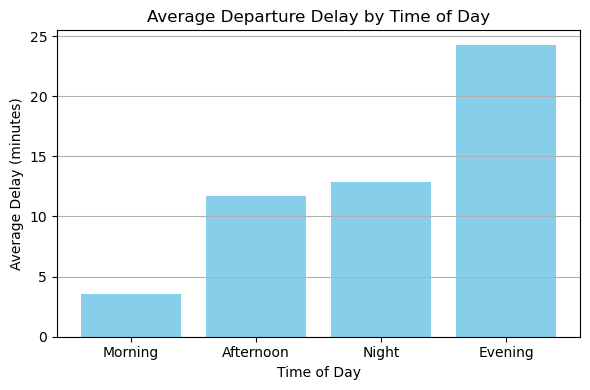

In [22]:
# Set memory-safe config for Tez
cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=tez")  # or 'mr' if Tez still fails

# Run query to calculate avg delay by time of day
cursor.execute('''
SELECT
  CASE
    WHEN CAST(DepTime AS INT) BETWEEN 000 AND 559 THEN 'Night'
    WHEN CAST(DepTime AS INT) BETWEEN 600 AND 1159 THEN 'Morning'
    WHEN CAST(DepTime AS INT) BETWEEN 1200 AND 1759 THEN 'Afternoon'
    WHEN CAST(DepTime AS INT) BETWEEN 1800 AND 2359 THEN 'Evening'
  END AS timeOfDay,
  AVG(CAST(DepDelay AS DOUBLE)) AS avgDepDelay
FROM flightss
WHERE DepDelay IS NOT NULL AND DepTime IS NOT NULL
GROUP BY
  CASE
    WHEN CAST(DepTime AS INT) BETWEEN 000 AND 559 THEN 'Night'
    WHEN CAST(DepTime AS INT) BETWEEN 600 AND 1159 THEN 'Morning'
    WHEN CAST(DepTime AS INT) BETWEEN 1200 AND 1759 THEN 'Afternoon'
    WHEN CAST(DepTime AS INT) BETWEEN 1800 AND 2359 THEN 'Evening'
  END
ORDER BY avgDepDelay ASC
''')

rows = cursor.fetchall()
columns = [desc[0].lower() for desc in cursor.description]  # Normalize column names
df1 = pd.DataFrame(rows, columns=columns)

# Drop rows with missing values in x or y columns
df1 = df1.dropna(subset=['timeofday', 'avgdepdelay'])

# Plot
plt.figure(figsize=(6, 4))
plt.bar(df1['timeofday'], df1['avgdepdelay'], color='skyblue')
plt.title('Average Departure Delay by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

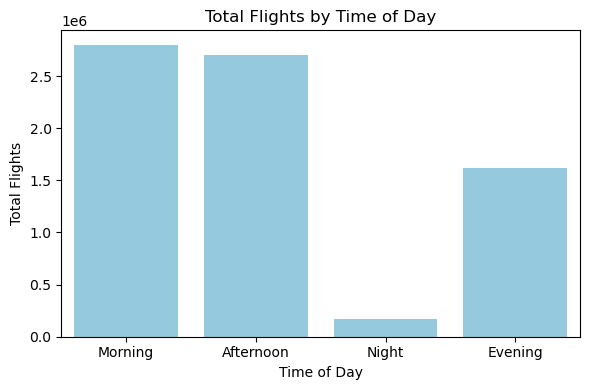

In [50]:
cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # use 'mr' if 'tez' gives memory error
cursor.execute('''
SELECT 
  CASE
    WHEN CAST(DepTime AS INT) BETWEEN 0 AND 559 THEN 'Night'
    WHEN CAST(DepTime AS INT) BETWEEN 600 AND 1159 THEN 'Morning'
    WHEN CAST(DepTime AS INT) BETWEEN 1200 AND 1759 THEN 'Afternoon'
    WHEN CAST(DepTime AS INT) BETWEEN 1800 AND 2359 THEN 'Evening'
  END AS timeofday,
  DayOfWeek AS dayofweek,
  Month AS month,
  COUNT(*) AS totalflights
FROM flightss
WHERE DepTime IS NOT NULL
GROUP BY 
  CASE
    WHEN CAST(DepTime AS INT) BETWEEN 0 AND 559 THEN 'Night'
    WHEN CAST(DepTime AS INT) BETWEEN 600 AND 1159 THEN 'Morning'
    WHEN CAST(DepTime AS INT) BETWEEN 1200 AND 1759 THEN 'Afternoon'
    WHEN CAST(DepTime AS INT) BETWEEN 1800 AND 2359 THEN 'Evening'
  END,
  DayOfWeek,
  Month
ORDER BY month,dayofweek
''')

# Fetch and load
rows = cursor.fetchall()
columns = [desc[0].lower() for desc in cursor.description]
df2 = pd.DataFrame(rows, columns=columns)

# Total flights by time of day
grouped_df2 = df2.groupby('timeofday')['totalflights'].sum().reset_index()
desired_order = ['Morning', 'Afternoon', 'Night', 'Evening']
plt.figure(figsize=(6, 4))
sns.barplot(data=grouped_df2, x='timeofday', y='totalflights', color='skyblue',
            order=desired_order,legend=False)
plt.title('Total Flights by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Total Flights')
plt.tight_layout()
plt.show()

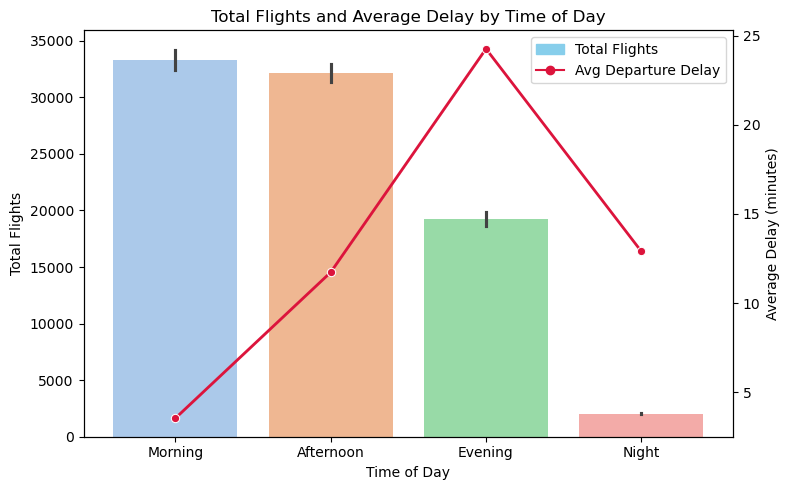

In [55]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Merge both on timeofday
merged_df = pd.merge(df1, df2, on='timeofday')

# Order
desired_order = ['Morning', 'Afternoon', 'Evening', 'Night']
merged_df['timeofday'] = pd.Categorical(merged_df['timeofday'], categories=desired_order, ordered=True)
merged_df = merged_df.sort_values('timeofday')

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot (Total Flights)
sns.barplot(data=merged_df, x='timeofday', y='totalflights', ax=ax1, hue='timeofday',
            palette='pastel', dodge=False)
ax1.set_ylabel('Total Flights')
ax1.set_xlabel('Time of Day')
ax1.tick_params(axis='y')

# Line plot (Average Delay)
ax2 = ax1.twinx()
sns.lineplot(data=merged_df, x='timeofday', y='avgdepdelay', ax=ax2, color='crimson', marker='o', linewidth=2)
ax2.set_ylabel('Average Delay (minutes)')
ax2.tick_params(axis='y')

# Custom legend
bar_patch = mpatches.Patch(color='skyblue', label='Total Flights')
line_patch = mlines.Line2D([], [], color='crimson', marker='o', label='Avg Departure Delay')
plt.legend(handles=[bar_patch, line_patch], loc='upper right')

# Title and layout
plt.title('Total Flights and Average Delay by Time of Day')
plt.tight_layout()
plt.show()

**EVENING MADNESS**

The plot shows that evening flights (6 PM – 12 AM) tend to experience the highest departure delays, despite having fewer total flights during that time. This pattern is likely the result of a cascading effect, where delays from earlier in the day accumulate. As the day progresses, from morning to afternoon and then into evening, the average delay steadily increases, ultimately impacting later departures the most.

In contrast, morning (6 AM - 12 PM) flights are usually more punctual. This could be because they’re often tied to business travel, where timeliness is a priority, and because they’re less affected by disruptions from earlier flights.

Night (12 AM - 6 AM) flights, on the other hand, generally face fewer delays, likely thanks to the reduced air traffic during those hours, which means fewer planes, fewer problems.

**Heads-Up Hotline**

- If flexibility allows, book earlier flights (morning or early afternoon) to reduce risk.

### DAYS AIRLINES PERFORMANCE

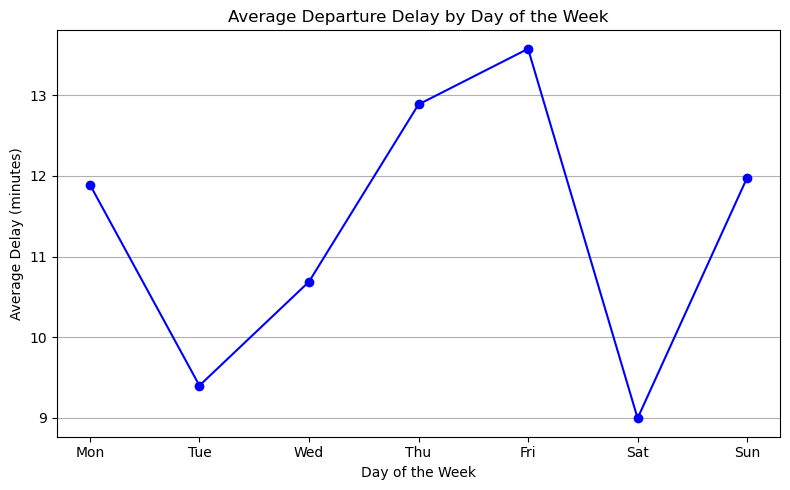

In [71]:
# Hive query (already executed earlier)
cursor.execute('''
SELECT 
  DayOfWeek AS dayOfWeek,
  DepDelay AS depDelay
FROM flightss
WHERE DayOfWeek IS NOT NULL 
AND DepDelay IS NOT NULL
''')

# Load into DataFrame
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(rows, columns=columns)

# Convert types
df['dayofweek'] = pd.to_numeric(df['dayofweek'], errors='coerce')
df['depdelay'] = pd.to_numeric(df['depdelay'], errors='coerce')

# Remove nulls
df = df.dropna(subset=['dayofweek', 'depdelay'])

# Group by day and calculate average
day_avg = df.groupby('dayofweek')['depdelay'].mean().reset_index()

# Map to day names
day_map = {
    1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu',
    5: 'Fri', 6: 'Sat', 7: 'Sun'
}
day_avg['dayofweek'] = day_avg['dayofweek'].astype(int).map(day_map)

# Sort day order
day_avg['dayofweek'] = pd.Categorical(day_avg['dayofweek'], 
                                      categories=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
                                      ordered=True)
day_avg = day_avg.sort_values('dayofweek')

# Plot
plt.figure(figsize=(8, 5))
plt.plot(day_avg['dayofweek'], day_avg['depdelay'], marker='o', linestyle='-', color='blue')
plt.title('Average Departure Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show() 

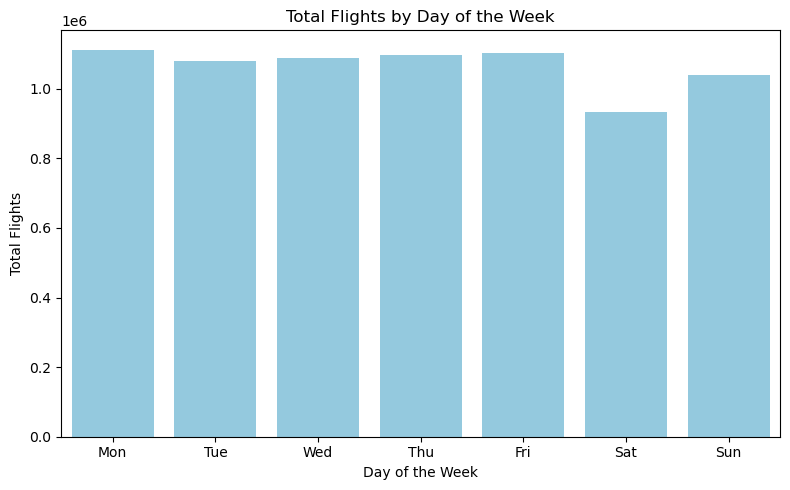

In [69]:
# Query total flights per day of week
cursor.execute('''
SELECT 
  DayOfWeek AS dayofweek,
  COUNT(*) AS totalflights
FROM flightss
GROUP BY DayOfWeek
ORDER BY DayOfWeek
''')

# Fetch and load into DataFrame
rows = cursor.fetchall()
columns = [desc[0].lower() for desc in cursor.description]
df = pd.DataFrame(rows, columns=columns)

# Convert to numeric
df['dayofweek'] = pd.to_numeric(df['dayofweek'], errors='coerce')
df['totalflights'] = pd.to_numeric(df['totalflights'], errors='coerce')

# Drop any rows with missing values
df_flights = df.dropna(subset=['dayofweek', 'totalflights'])

# Map day numbers to day names
day_map = {
    1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu',
    5: 'Fri', 6: 'Sat', 7: 'Sun'
}
df_flights['dayofweek'] = df['dayofweek'].astype(int).map(day_map)

# Set day order
df_flights['dayofweek'] = pd.Categorical(df_flights['dayofweek'],
                                categories=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
                                ordered=True)
df_flights = df_flights.sort_values('dayofweek')

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='dayofweek', y='totalflights', data=df_flights, color='skyblue')
plt.title('Total Flights by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Flights')
plt.tight_layout()
plt.show()

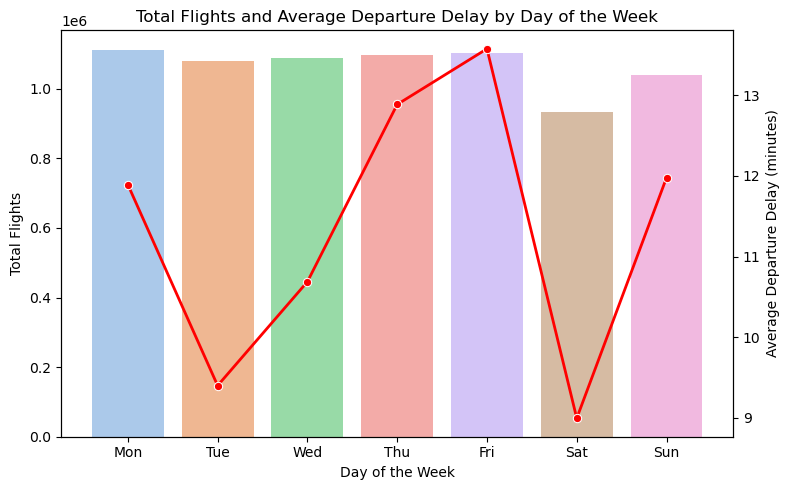

In [75]:
# Merge the two DataFrames on 'dayofweek'
merged_df2 = pd.merge(day_avg, df_flights, on='dayofweek')

# Plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Bar plot for total flights
sns.barplot(data=merged_df2, x='dayofweek', y='totalflights', hue='dayofweek', ax=ax1,
           palette='pastel',dodge=False)
ax1.set_ylabel('Total Flights')
ax1.set_xlabel('Day of the Week')

# Line plot for average delay on second y-axis
ax2 = ax1.twinx()
sns.lineplot(data=merged_df2, x='dayofweek', y='depdelay', color='red', marker='o', linewidth=2, ax=ax2)
ax2.set_ylabel('Average Departure Delay (minutes)')

# Title and layout
plt.title('Total Flights and Average Departure Delay by Day of the Week')
plt.tight_layout()
plt.show()

**GROUNDED DAY?**

The plot shows that Friday has the highest average departure delay (around 14 minutes) followed closely by Thursday. This may be due to the end-of-week business rush and the popular trend of weekend getaways. Not surprisingly, the total number of flights on these days is also high, adding to the congestion.

Monday and Sunday also show noticeable delays, possibly reflecting the surge of return and start-of-week travel.

In contrast, Tuesday and Saturday have the lowest average delays. Saturday’s lower delay is likely due to fewer total flights. But Tuesday is the real standout: despite having a high number of flights, it sees the least delay. Could it be that Tuesday is simply the most efficient travel day of the week?

**Heads-Up Hotline**

Tuesday is often the cheapest day of the week to fly, according to data from Experian. It’s a bit of a travel jackpot: fewer delays, lower fares, and less airport chaos compared to peak days like Friday or Sunday.
https://www.experian.com/blogs/ask-experian/cheapest-days-to-fly/

### MONTHS AIRLINES PERFORMANCE

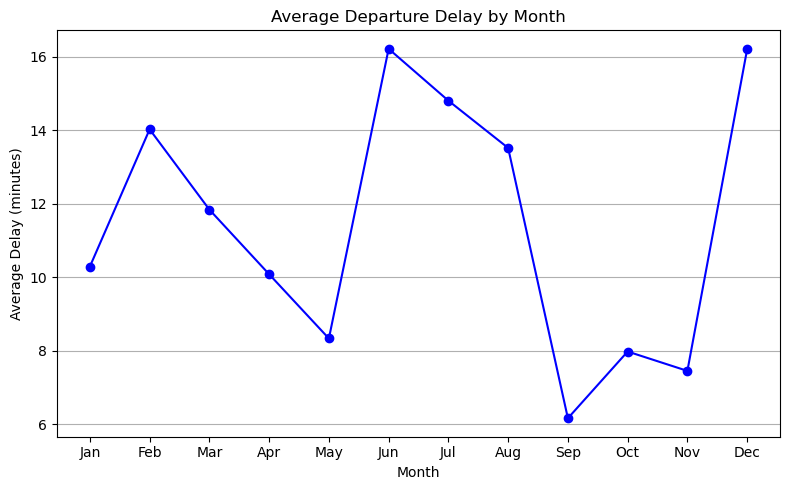

In [90]:
# months on time

# Execute Hive query
cursor.execute('''
SELECT 
  Month AS month,
  DepDelay AS depDelay
FROM flightss
WHERE month IS NOT NULL 
AND DepDelay IS NOT NULL
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

# Create DataFrame
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df['depdelay'] = pd.to_numeric(df['depdelay'], errors='coerce')

# Drop rows with missing or invalid values
df_M = df.dropna(subset=['month', 'depdelay'])

# Group and average
monthly_avg = df_M.groupby('month')['depdelay'].mean().reset_index()

# Map month numbers to names (optional)
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
monthly_avg['month'] = monthly_avg['month'].astype(int).map(month_map)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(monthly_avg['month'], monthly_avg['depdelay'], marker='o', linestyle='-', color='blue')
plt.title('Average Departure Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

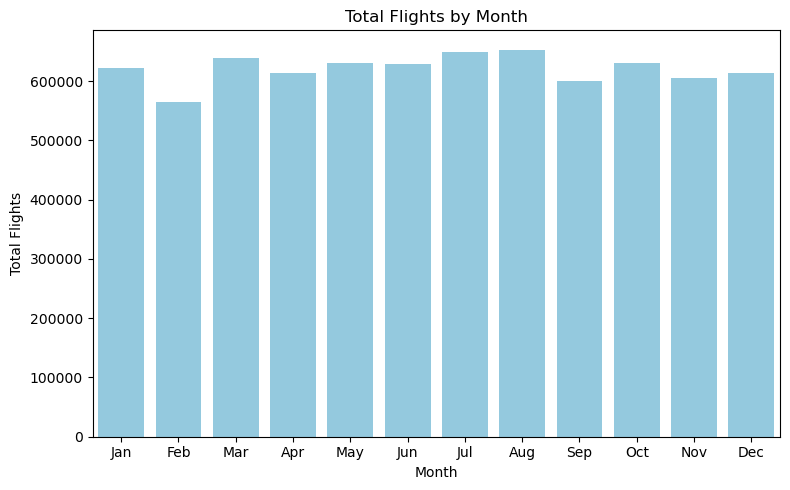

In [88]:
# Run the query to get total flights per month
cursor.execute('''
SELECT 
  Month AS month,
  COUNT(*) AS totalflights
FROM flightss
GROUP BY Month
ORDER BY Month
''')

# Fetch and load into DataFrame
rows = cursor.fetchall()
columns = [desc[0].lower() for desc in cursor.description]
df = pd.DataFrame(rows, columns=columns)

# Convert 'month' and 'totalflights' to numeric just to be safe
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df['totalflights'] = pd.to_numeric(df['totalflights'], errors='coerce')

# Drop any NA rows just in case
df_flightM = df.dropna(subset=['month', 'totalflights'])

# Plot total flights by month
plt.figure(figsize=(8,5))
sns.barplot(x='month', y='totalflights', data=df_flightM, color='skyblue')
plt.title('Total Flights by Month')
plt.xlabel('Month')
plt.ylabel('Total Flights')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

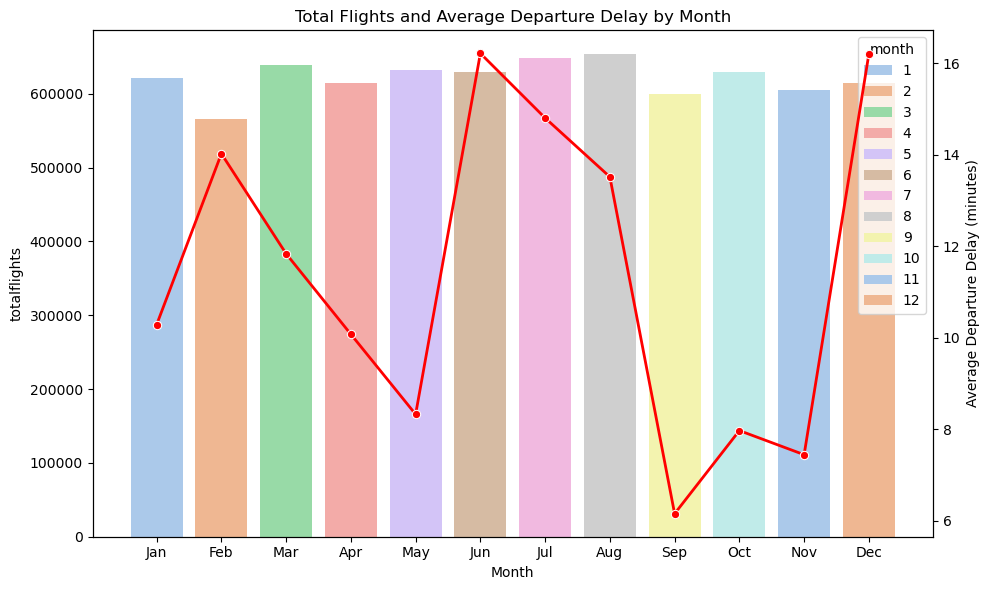

In [96]:
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total flights by month on the left axis (bar plot)
sns.barplot(x='month', y='totalflights', data=df_flightM, hue='month', ax=ax1,
            palette='pastel', dodge=False)
ax1.set_xlabel('Month')

# Create a second y-axis to plot average delay (line plot)
ax2 = ax1.twinx()
sns.lineplot(data=monthly_avg, x='month', y='depdelay', color='red', marker='o', linewidth=2, ax=ax2)
ax2.set_ylabel('Average Departure Delay (minutes)')

# Title and layout
plt.title('Total Flights and Average Departure Delay by Month')
plt.tight_layout()
plt.show()

**6-MONTHLY HAVOC**

The plot reveals that June and December have the highest average departure delays, coinciding with peak holiday seasons: summer vacations and year-end festivities. Although these months do not have the highest flight volumes, delays may be driven by holiday congestion, staff shortages, and seasonal weather issues.

From June to August, delays remain consistently high due to the summer travel rush, then gradually decrease before dropping sharply in September, which marks the end of the school holiday period.

February also shows a noticeable spike in delays, which could be attributed to unpredictable winter weather, despite being a less busy travel month. https://en.wikipedia.org/wiki/February_2014_nor%27easter

In contrast, the period from September to November sees the lowest average delays, likely reflecting reduced travel demand and more stable operational conditions. May also performs well, possibly because it precedes the summer peak and avoids the associated chaos.

**Heads-Up Hotline**

May and early autumn might just be your best bets for flying smart.

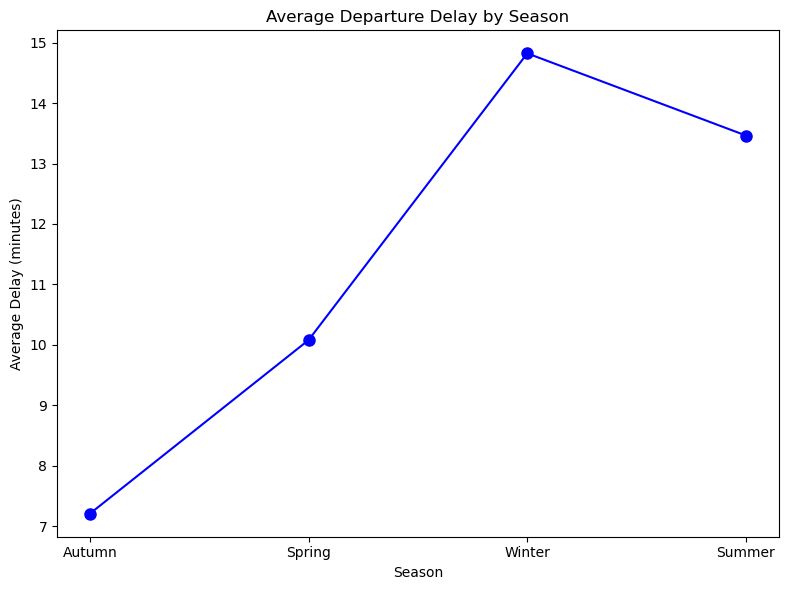

In [170]:
# Set Tez memory (for sorting I/O) and execution engine
cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # Switch to MR if Tez causes memory issues

# Correct SQL query with the comma fixed
cursor.execute('''
SELECT 
    CASE 
        WHEN Month IN (12,1,2) THEN 'Winter' 
        WHEN Month IN (3,4,5) THEN 'Spring' 
        WHEN Month IN (6,7,8) THEN 'Summer' 
        WHEN Month IN (9,10,11) THEN 'Autumn'
    END AS Season,
    AVG(CASE WHEN depDelay IS NULL THEN 0 ELSE depDelay END) AS avgDelay
FROM flightss
GROUP BY 
    CASE 
        WHEN Month IN (12,1,2) THEN 'Winter' 
        WHEN Month IN (3,4,5) THEN 'Spring' 
        WHEN Month IN (6,7,8) THEN 'Summer' 
        WHEN Month IN (9,10,11) THEN 'Autumn'
    END
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

# Map seasons to numerical values
df_season = df.sort_values(by='avgdelay')

# Plotting using plt.plot()
plt.figure(figsize=(8, 6))
plt.plot(df_season['season'], df['avgdelay'], marker='o', color='blue', linestyle='-', markersize=8)
plt.title('Average Departure Delay by Season')
plt.xlabel('Season')
plt.ylabel('Average Delay (minutes)')
plt.tight_layout()
plt.show()

In [173]:
df_season.head()

season   avgdelay
0  Autumn   7.205963
1  Spring  10.078970
3  Winter  13.463579
2  Summer  14.823519

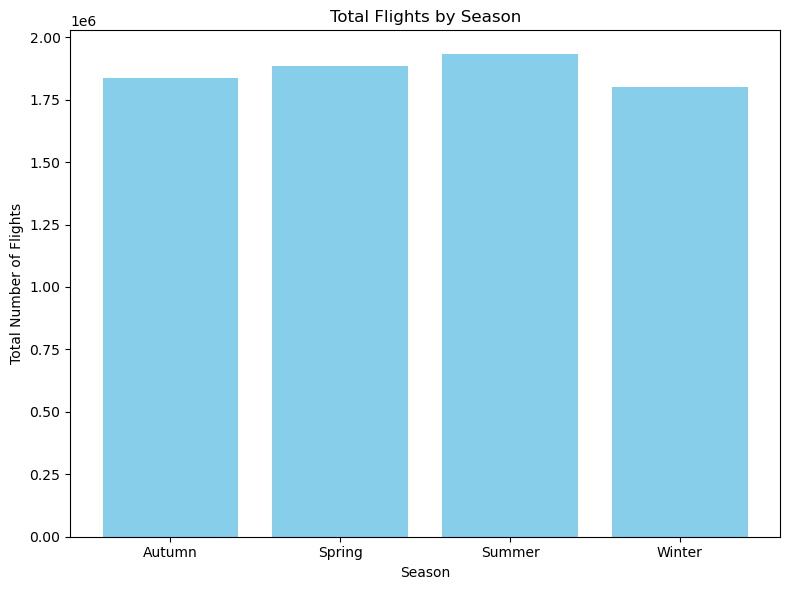

In [177]:
# Execute the query (assuming cursor is connected to Hive)
cursor.execute(''' 
SELECT 
    CASE 
        WHEN Month IN (12,1,2) THEN 'Winter' 
        WHEN Month IN (3,4,5) THEN 'Spring' 
        WHEN Month IN (6,7,8) THEN 'Summer' 
        WHEN Month IN (9,10,11) THEN 'Autumn'
    END AS Season,
    COUNT(*) AS totalflights
FROM flightss
GROUP BY 
    CASE 
        WHEN Month IN (12,1,2) THEN 'Winter' 
        WHEN Month IN (3,4,5) THEN 'Spring' 
        WHEN Month IN (6,7,8) THEN 'Summer' 
        WHEN Month IN (9,10,11) THEN 'Autumn'
    END
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df_F = pd.DataFrame(rows, columns=columns)

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(df_F['season'], df_F['totalflights'], color='skyblue')
plt.title('Total Flights by Season')
plt.xlabel('Season')
plt.ylabel('Total Number of Flights')
plt.tight_layout()
plt.show()

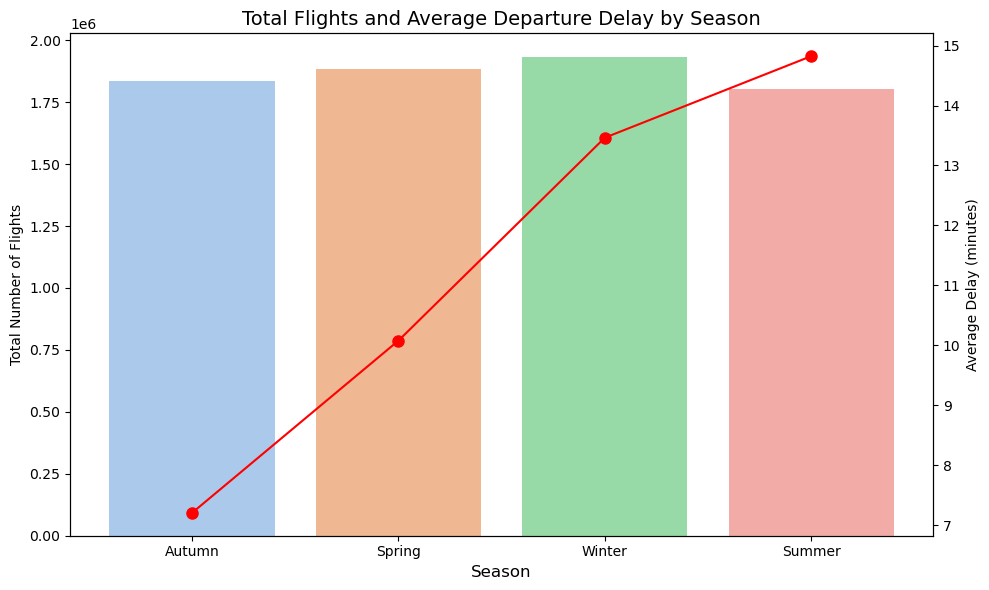

In [185]:
import matplotlib.pyplot as plt

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the total flights as a bar plot on the first axis (ax1)
sns.barplot(x='season', y='totalflights', data=df_F, hue='season', ax=ax1, palette='pastel', dodge=False)
ax1.set_xlabel('Season', fontsize=12)
ax1.set_ylabel('Total Number of Flights')

# Create a second y-axis to plot the average delay
ax2 = ax1.twinx()
ax2.plot(df_season['season'], df_season['avgdelay'], marker='o', color='red', linestyle='-', markersize=8)
ax2.set_ylabel('Average Delay (minutes)')

# Set the title and adjust layout
plt.title('Total Flights and Average Departure Delay by Season', fontsize=14)
plt.tight_layout()
plt.show()

**SUMMER MAYHEM**

This relates with earlier findings where June to August (summer season) shows the highest average departure delays, even though the total number of flights is lower than in other seasons. A likely reason is staff shortages during peak vacation time.

In contrast, the winter season brings unpredictable weather, contributing to significant delays. It also sees the highest total flight volume, likely driven by year-end festivities and holiday travel.

Meanwhile, autumn (September to November) experiences the least departure delays, possibly due to more stable weather and the end of school holidays, resulting in reduced air traffic and smoother operations.

**Heads-up Hotline**

Autumn is a pleasant season for travel due to favourable weather and cheaper airfare, plus extra hospitality during off-season travel months. https://www.sevencorners.com/blog/travel-tips/why-you-should-travel-internationally-this-fall

## DELAY FACTORS

For this phase of the analysis, we examine the specific causes of flight delays using the following fields from 2007.csv (table name: flightss):

- CarrierDelay: Delay (in minutes) caused by the airline itself (e.g., maintenance, crew issues).

- WeatherDelay: Delay due to weather conditions (e.g., storms, low visibility).

- NASDelay: Delay caused by the National Airspace System, including air traffic congestion, airport operations, and non-extreme weather.

- SecurityDelay: Delay resulting from security-related events or procedures.

- LateAircraftDelay: Delay caused by a late-arriving aircraft from a previous flight segment.

So far, we have identified time of day, day of the week, month, and seasonal patterns associated with frequent delays. In the next step, we will delve deeper into these delay factors to understand which causes are most responsible for the disruptions.

In [186]:
# top 3-5 factors contributing to flight delay
# Quantify the impact of each factor (in minutes of delay and percentage of total delays)

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT
  SUM(CarrierDelay) AS carrier,
  SUM(WeatherDelay) AS weather,
  SUM(NASDelay) AS nas,
  SUM(SecurityDelay) AS security,
  SUM(LateAircraftDelay) AS lateaircraft
FROM flightss
WHERE CarrierDelay IS NOT NULL 
   OR WeatherDelay IS NOT NULL 
   OR NASDelay IS NOT NULL 
   OR SecurityDelay IS NOT NULL 
   OR LateAircraftDelay IS NOT NULL
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

# Step 2: Transpose and clean
df = df.T.reset_index()
df.columns = ['Reason', 'TotalMinutes']

# Calculate percentage
df['Percent'] = (df['TotalMinutes'] / df['TotalMinutes'].sum()) * 100

# Sort descending by impact
df = df.sort_values(by='TotalMinutes', ascending=False)
df['Reason'] = df['Reason'].astype(str)

# Display results
df

Reason  TotalMinutes    Percent
4  lateaircraft    38004942.0  37.654500
0       carrier    28808434.0  28.542793
2           nas    28200746.0  27.940708
1       weather     5739649.0   5.686724
3      security      176906.0   0.175275

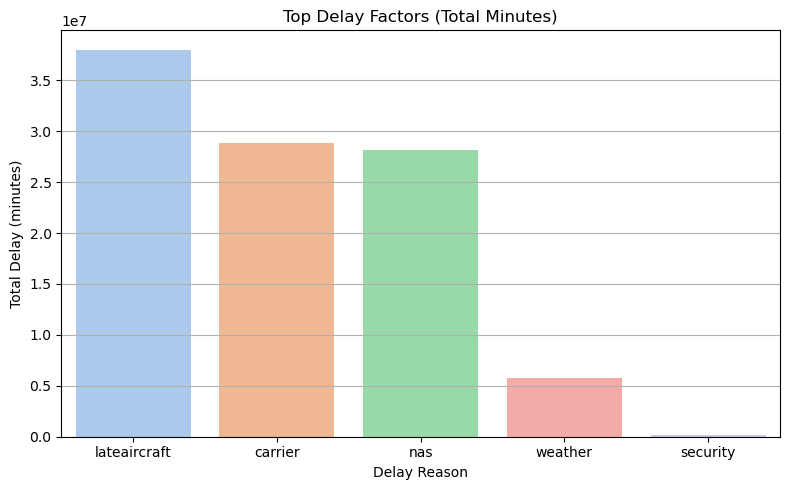

In [191]:
# Plot: Total delay in minutes
plt.figure(figsize=(8, 5))
sns.barplot(x='Reason', y='TotalMinutes', data=df, hue='Reason', palette='pastel', dodge=False)
plt.title('Top Delay Factors (Total Minutes)')
plt.xlabel('Delay Reason')
plt.ylabel('Total Delay (minutes)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

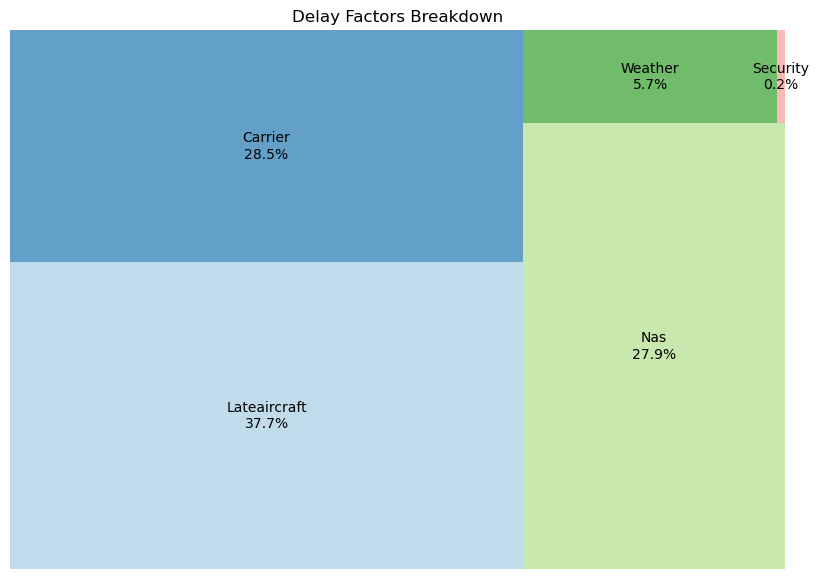

In [199]:
import squarify
import matplotlib.pyplot as plt

# Data for Treemap
labels = df['Reason'].str.title()
sizes = df['TotalMinutes']
total_delay = sizes.sum()  # Total delay for percentage calculation
percentages = (sizes / total_delay) * 100  # Calculate the percentage for each reason
colors = plt.cm.Paired.colors

# Plot the treemap with percentages
plt.figure(figsize=(10, 7))

# Create a label with percentages included
labels_with_percent = [f'{label}\n{percent:.1f}%' for label, percent in zip(labels, percentages)]

# Plot the treemap
squarify.plot(sizes=sizes, label=labels_with_percent, color=colors, alpha=0.7)

# Title and aesthetics
plt.title('Delay Factors Breakdown')
plt.axis('off')  # Turn off axis to make it clean
plt.show()


**LATE TAKES OFF LATE**

As highlighted in our earlier findings, evening flight delays are often the result of a cascading effect, where one delay triggers another throughout the day. A major contributor to this is Late Aircraft Delay, which makes up 37.7% of all departure delays, averaging over 104,000 minutes per day.

Next is Carrier Delay, responsible for 28.5% of delays, or around 78,933 minutes daily. These are typically caused by airline-specific issues, such as mechanical problems, crew availability, or operational constraints.

NAS (National Airspace System) Delays follow closely at 27.9%, averaging 77,260 minutes per day. These are primarily due to air traffic congestion, runway limitations, and other airspace management challenges.

Surprisingly, Weather Delays account for just 5.7% of total departure delays (around 15,722 minutes per day), typically caused by hazardous conditions like storms, fog, or snow that, while infrequent, can severely disrupt operations.

Finally, Security Delays make up a minimal 0.2%, averaging just 485 minutes per day. Fortunately, this means that TSA lines or other security-related issues rarely cause major disruptions to flight schedules.

**Heads-up Hotline**

Googling your airline’s reviews goes a long way. A quick check can save you from a turbulent travel experience before you even book.

## PROBLEMATIC ROUTES

### SPECIFICALLY TO CARRIER

For this analysis of identifying specific carriers with the most frequent delays, we used the following:

flightss table (from 2007.csv) containing:

- UniqueCarrier – airline carrier code

- DepDelay – departure delay in minutes

carriers table (from carriers.csv) containing:

- Code – carrier code

- Description – full airline name

The two tables were joined on: flightss.UniqueCarrier = carriers.Code

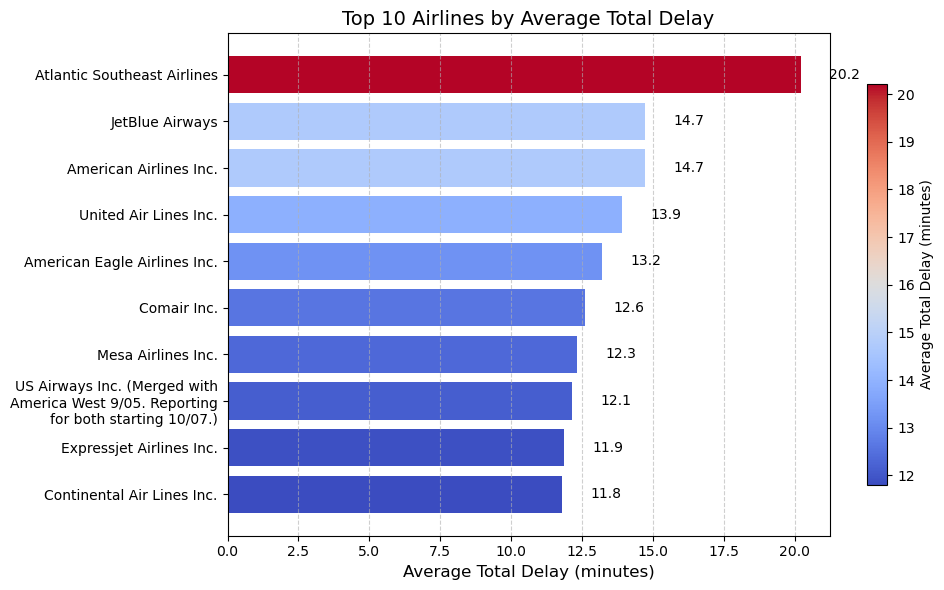

In [252]:
# Identify specific carriers

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  f.UniqueCarrier,
  c.Description AS airline_name,
  AVG(f.DepDelay) AS avg_total_delay,
  COUNT(*) AS total_flights
FROM flightss f
JOIN carrierss c
  ON f.UniqueCarrier = c.Code
WHERE f.DepDelay IS NOT NULL
GROUP BY f.UniqueCarrier, c.Description
ORDER BY avg_total_delay DESC
LIMIT 10
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

import matplotlib.pyplot as plt
import pandas as pd
import textwrap
import numpy as np

# Sort by average total delay in descending order
df_sorted = df.sort_values('avg_total_delay', ascending=False)

# Wrap long airline names to multiple lines
def wrap_labels(label, width=30):
    return "\n".join(textwrap.wrap(label, width))

# Apply label wrapping
df_sorted['label'] = df_sorted['airline_name'].apply(lambda x: wrap_labels(x, width=30))

# Create a color palette using a colormap (e.g., 'coolwarm', 'viridis', etc.)
# Normalize delay values for color mapping
norm = plt.Normalize(df_sorted['avg_total_delay'].min(), df_sorted['avg_total_delay'].max())
cmap = plt.get_cmap('coolwarm')  # You can choose a different colormap here

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axis explicitly
bars = ax.barh(df_sorted['label'], df_sorted['avg_total_delay'], color=cmap(norm(df_sorted['avg_total_delay'])))

# Add colorbar for the gradient
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array to create colorbar
fig.colorbar(sm, ax=ax, label='Average Total Delay (minutes)', shrink=0.8)

# Adding labels and title
ax.set_xlabel('Average Total Delay (minutes)', fontsize=12)
ax.set_title('Top 10 Airlines by Average Total Delay', fontsize=14)

# Invert y-axis to have the highest delays at the top
ax.invert_yaxis()

# Adding grid lines to the x-axis
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate bars with delay values
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.1f}', va='center', color='black', fontsize=10)

# Adjust layout for better spacing
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show plot
plt.show()

**RUN A WAY AIRLINES**

The plot displays the top 10 airlines with the highest average departure delays.
Atlantic Southeast Airlines ranks first with an average delay of 20 minutes, making it the most delay-prone carrier.

Tied in second place are JetBlue Airways and American Airlines, both with an average delay of 14.7 minutes.

The remaining airlines on the list have average delays ranging from 13.9 minutes down to 1.8 minutes, with a mean delay of approximately 8.9 minutes across these carriers.

In [263]:
# Atlantic

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  f.UniqueCarrier, 
  c.Description AS airline_name, 
  COUNT(*) AS total_flights,
  AVG(f.DepDelay) AS avg_total_delay,
  COUNT(CASE WHEN f.DepDelay > 0 THEN 1 END) AS delayed_flights
FROM flightss f
JOIN carrierss c
  ON f.UniqueCarrier = c.Code
WHERE f.UniqueCarrier = 'EV'
GROUP BY f.UniqueCarrier, c.Description
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)
df.head()

f.uniquecarrier                 airline_name  total_flights  \
0              EV  Atlantic Southeast Airlines         286234   

   avg_total_delay  delayed_flights  
0        20.220919           147254

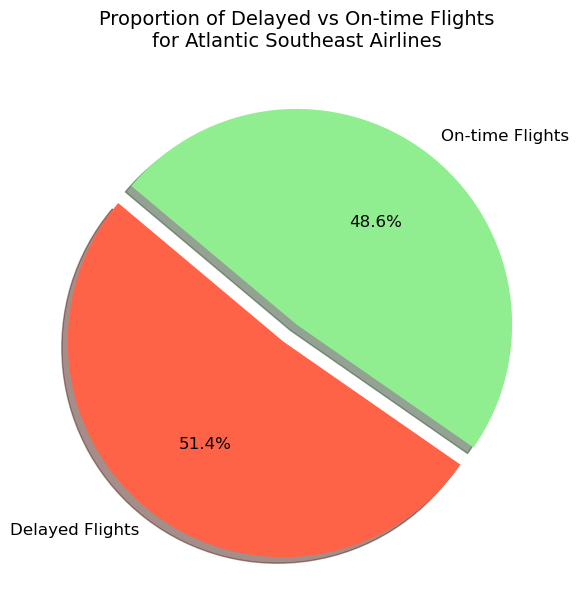

In [265]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data based on the result you provided
data = {
    'airline_name': ['Atlantic Southeast Airlines'],
    'total_flights': [286234],
    'delayed_flights': [147254]
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate number of on-time flights
on_time_flights = df['total_flights'] - df['delayed_flights']

# Data for the pie chart
labels = ['Delayed Flights', 'On-time Flights']
sizes = [df['delayed_flights'][0], on_time_flights[0]]
colors = ['#FF6347', '#90EE90']  # Red for delayed, Green for on-time
explode = (0.1, 0)  # Explode the 'Delayed Flights' slice for emphasis

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode,
        shadow=True, textprops={'fontsize': 12})

# Title
plt.title('Proportion of Delayed vs On-time Flights\nfor Atlantic Southeast Airlines', fontsize=14)

# Show the plot
plt.show()

**HALF THE TIME... NOT ON TIME**

With 51.4% of its flights delayed, Atlantic Southeast Airlines operates with more delays than on-time arrivals, making it a carrier travelers may want to avoid when punctuality is a priority. The pie chart clearly shows that over half of its operations fail to depart or arrive on schedule.

In 2007, Atlantic Southeast Airlines (ASA) faced a major operational crisis, driven by a prolonged labor dispute with its pilots and a severe pilot shortage, resulting in an 18% annual attrition rate. These issues contributed to ASA completing only 56% of its flights on time in June, the worst on-time performance among 20 major U.S. carriers.
https://www.deseret.com/2007/9/1/20038774/skywest-asa-unit-pilots-fail-to-resolve-a-5-year-dispute

### SPECIFICALLY TO ROUTES

To analyze delay patterns across different airports by examining departure delays in relation to their origin and destination codes, we used the following fields from 2007.csv (table name: flightss):

- Origin – origin airport IATA code

- Dest – destination airport IATA code

- DepDelay – difference in minutes between the scheduled and actual departure time (negative values indicate early departures)

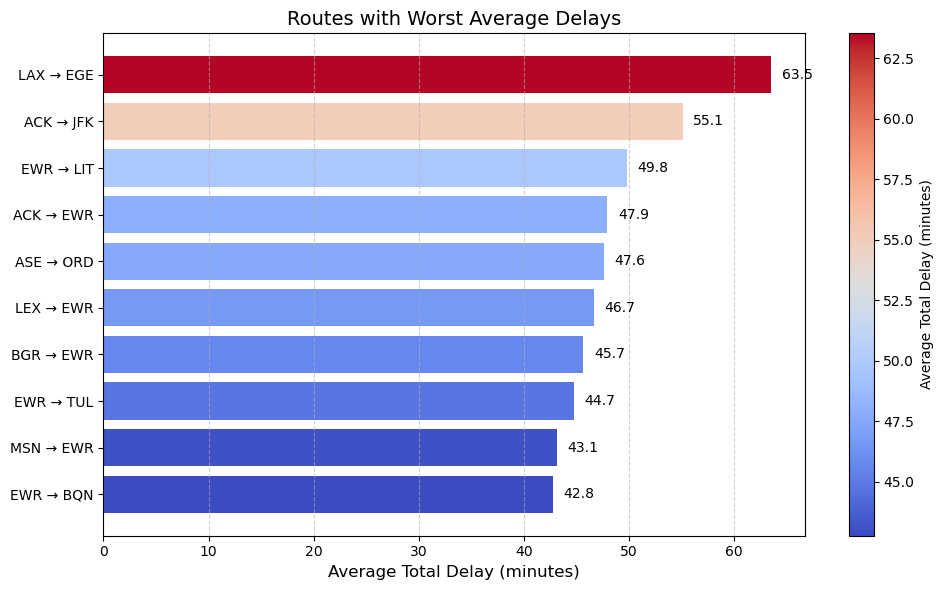

In [243]:
# Identify specific routes

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  Origin,
  Dest,
  AVG(DepDelay) AS avg_total_delay,
  COUNT(*) AS flight_count
FROM flightss
WHERE DepDelay IS NOT NULL
GROUP BY Origin, Dest
HAVING COUNT(*) > 100  
ORDER BY avg_total_delay DESC
LIMIT 10
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data (Assuming 'df' is already provided)
# For demonstration, let's assume 'df' contains 'origin', 'dest', 'avg_total_delay', etc.
df['route'] = df['origin'] + " → " + df['dest']

# Sort by average delay in descending order
df_sorted = df.sort_values('avg_total_delay', ascending=False)

# Create a color palette using a colormap (e.g., 'coolwarm', 'viridis', etc.)
# Normalize delay values for color mapping
norm = plt.Normalize(df_sorted['avg_total_delay'].min(), df_sorted['avg_total_delay'].max())
cmap = plt.get_cmap('coolwarm')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axis explicitly
bars = ax.barh(df_sorted['route'], df_sorted['avg_total_delay'], color=cmap(norm(df_sorted['avg_total_delay'])))

# Add colorbar for the gradient
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array to create colorbar
fig.colorbar(sm, ax=ax, label='Average Total Delay (minutes)')  # Use 'ax' argument

# Adding labels and title
ax.set_xlabel('Average Total Delay (minutes)', fontsize=12)
ax.set_title('Routes with Worst Average Delays', fontsize=14)

# Invert y-axis to have the worst delays at the top
ax.invert_yaxis()

# Adding grid lines to the x-axis
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate bars with delay values
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.1f}', va='center', color='black', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


**ROUTE ROULETTE**

From the plot, we can see that the most delayed route is LAX → EGE (Los Angeles → Eagle, CO), with an average delay of 63.5 minutes. This route tops the list, likely due to mountain weather, limited runway capacity, and peak-season ski traffic, making it a consistent leader in late departures.

Next is ACK → EWR (Nantucket → Newark), averaging 55.1 minutes of delay. Despite being a short-haul flight, it frequently encounters delays due to regional airspace congestion and unpredictable New England weather.

In third place is ASE → ORD (Aspen → Chicago O’Hare), with an average delay of 49.8 minutes. The combination of a high-altitude mountain airport and a major hub destination, especially during the winter travel season, makes this route particularly vulnerable to disruptions.

- Other Delay-Prone Routes (40+ min average delay):

Newark’s role as a busy hub with limited runway space and high air traffic density makes it a notable hotspot for delay-prone routes, especially when paired with regional or island destinations.

EWR → LIT (Newark, NJ → Little Rock, AR), LEX → EWR (Lexington, KY → Newark, NJ), EWR → TUL (Newark, NJ → Tulsa, OK)

- EWR suffers from persistent congestion and heavy traffic, which significantly contributes to delays on these East Coast and Midwest routes.

BGR → EWR (Bangor, ME → Newark, NJ), HDN → ORD (Hayden, CO → Chicago O’Hare, IL)

- Flights from smaller regional airports like Bangor and Hayden into major hubs often experience longer delays due to limited infrastructure and tight scheduling.

EWR → BQN (Newark, NJ → Aguadilla, Puerto Rico), STT → PHL (St. Thomas, USVI → Philadelphia, PA)

- Routes from island destinations are frequently delayed by tropical weather patterns and high seasonal travel demand, especially during holidays and vacation peaks.


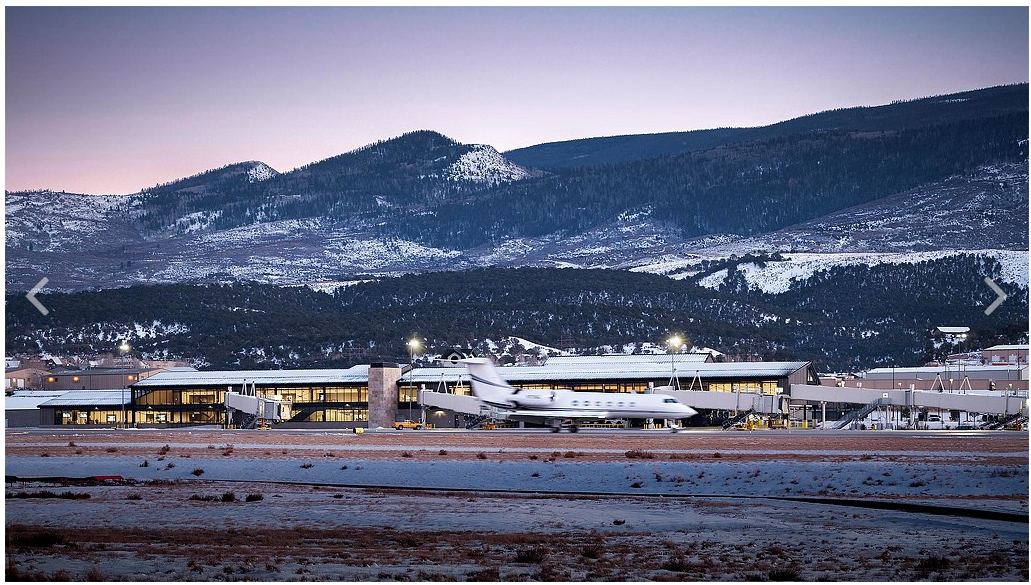

**Eagle County Regional Airport (EGE)** is best known as the primary gateway to Colorado’s renowned ski resorts, including Vail and Beaver Creek. It attracts a high volume of winter travelers, including charter flights and high-profile visitors heading to the slopes. What makes EGE particularly challenging is its location at a high elevation of 6,547 feet, which affects aircraft performance, especially during takeoff and landing. The airport is surrounded by mountainous terrain, requiring complex flight approaches, and it frequently experiences winter weather disruptions such as snow, wind, and low visibility. Additionally, EGE operates with a single runway, limiting its operational flexibility during peak travel periods or adverse conditions. https://flyapg.com/blog/top-5-most-challenging-us-airports-performance-data

### SPECIFIC FLIGHT NUMBERS

To analyze flight performance in greater detail, we focused on individual flight numbers using data from the 2007 flight records (2007.csv). The analysis utilized the following key fields:

From 2007.csv (table name: flightss):

- UniqueCarrier: Airline code

- FlightNum: Flight number identifier

- Origin / Dest: IATA airport codes for departure and arrival

- DepDelay: Departure delay in minutes (negative values indicate early departures)

- CarrierDelay: Delay caused by airline-related issues (e.g., crew, maintenance)

- WeatherDelay: Delay due to weather (storms, low visibility, etc.)

- NASDelay: Delay from the National Airspace System (e.g., congestion, traffic control)

- SecurityDelay: Delay due to security-related incidents

- LateAircraftDelay: Delay caused by late-arriving aircraft from a previous segment

- TailNum: Aircraft tail number

From plane_data.csv (Table name: planess):

- model: Aircraft model 

- year: Aircraft manufacture year

- TailNum: Aircraft tail number

These two datasets were joined using the TailNum field to link each flight with its specific aircraft.

<Figure size 1200x600 with 0 Axes>

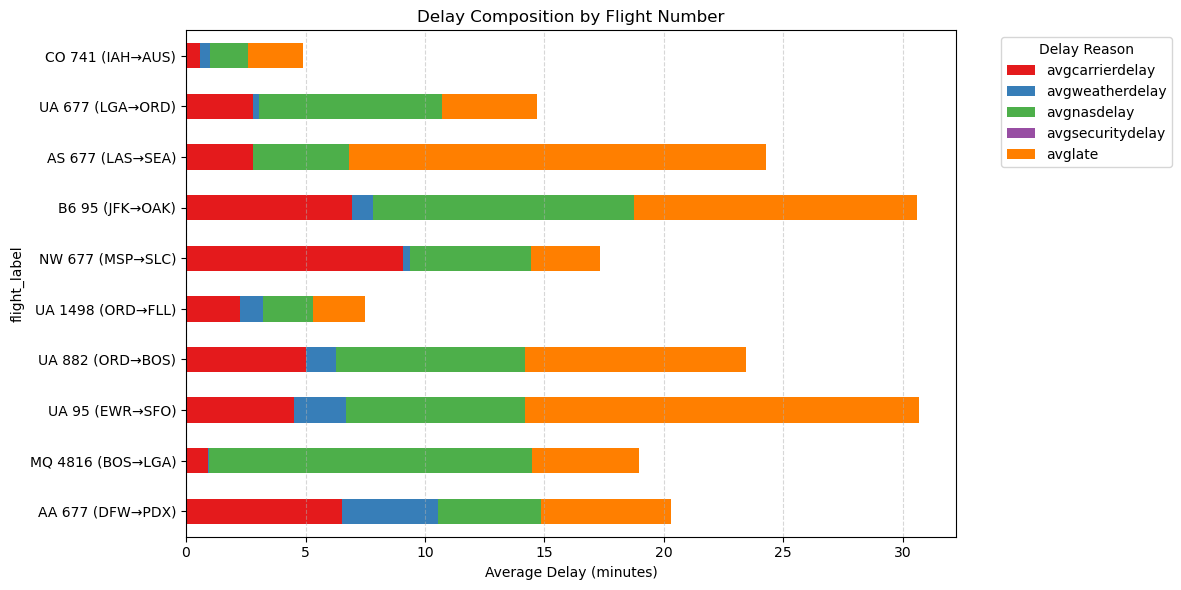

In [65]:
# Delay cause per flight

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  UniqueCarrier,
  FlightNum,
  Origin,
  Dest,
  AVG(CarrierDelay) AS avgCarrierDelay,
  AVG(WeatherDelay) AS avgWeatherDelay,
  AVG(NASDelay) AS avgNasDelay,
  AVG(SecurityDelay) AS avgSecurityDelay,
  AVG(LateAircraftDelay) AS avgLate,
  COUNT(*) AS flightCount
FROM flightss
WHERE FlightNum IN  (882, 2875, 677, 4816, 2185, 2696, 4329, 1498, 95, 741)  
GROUP BY UniqueCarrier, FlightNum, Origin, Dest
ORDER BY flightCount DESC
LIMIT 10
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

# Combine into a single label column for clarity
df['flight_label'] = (
    df['uniquecarrier'] + ' ' + df['flightnum'].astype(str) +
    ' (' + df['origin'] + '→' + df['dest'] + ')'
)

# Set index to label
df.set_index('flight_label', inplace=True)

# Keep only relevant delay columns
delay_cols = [
    'avgcarrierdelay', 'avgweatherdelay', 'avgnasdelay', 'avgsecuritydelay', 'avglate'
]
df[delay_cols] = df[delay_cols].fillna(0)

# Plot stacked horizontal bar chart
plt.figure(figsize=(12, 6))
df[delay_cols].plot(kind='barh', stacked=True, figsize=(12, 6),
                    color=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00'])

plt.xlabel('Average Delay (minutes)')
plt.title('Delay Composition by Flight Number')
plt.legend(title='Delay Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


**EYEING 677**

From the plot above, we can observe that flight number 677 appears frequently across multiple carriers (AS, NW, AA, UA). Notably, two of these instances are primarily delayed due to carrier-related issues, indicating recurring operational challenges tied to this flight number.

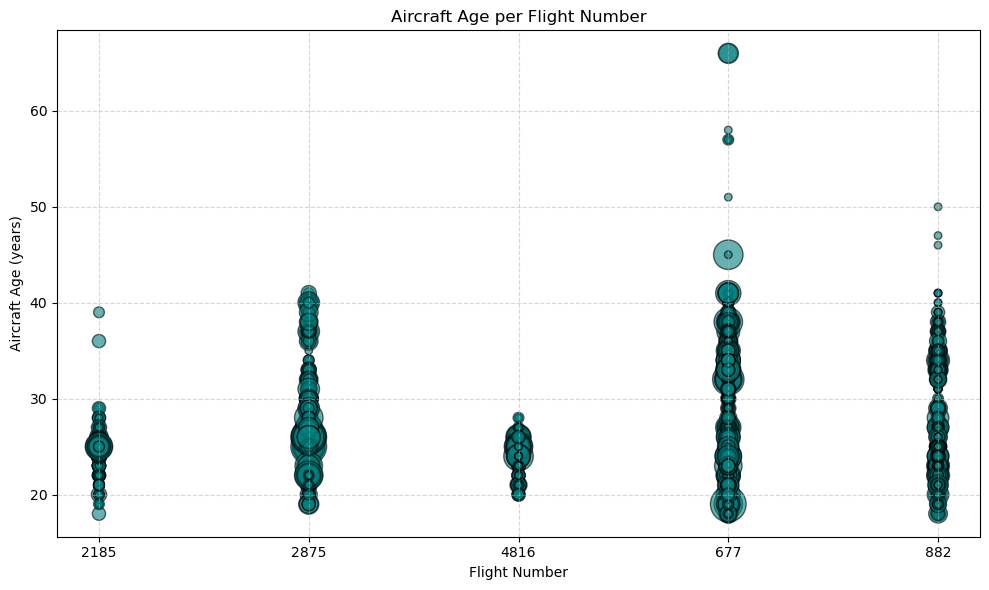

In [71]:
# Delay cause per flight

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  f.FlightNum, f.TailNum, p.model, p.year, COUNT(*) AS flights
FROM flightss f
JOIN planess p
  ON f.TailNum = p.tailnum
WHERE f.FlightNum IN (882, 2875, 677, 4816, 2185)
GROUP BY f.FlightNum, f.TailNum, p.model, p.year
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

# Convert year to age
df['p.year'] = pd.to_numeric(df['p.year'], errors='coerce')
df['aircraft_age'] = 2025 - df['p.year']  # or use datetime.now().year

# Create label for flights
df['flight_label'] = df['f.flightnum'].astype(str)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['flight_label'], df['aircraft_age'], s=df['flights'] * 30, alpha=0.6, color='teal', edgecolors='black')

plt.title('Aircraft Age per Flight Number')
plt.xlabel('Flight Number')
plt.ylabel('Aircraft Age (years)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**EYEING 677**

From the Delay Composition by Flight Number plot, flight number 677 appears repeatedly across different carriers (AS, NW, AA, UA). In at least two instances, delays are primarily due to carrier-related issues, indicating recurring operational inefficiencies.

Meanwhile, the Aircraft Age per Flight Number plot shows that Flight 677 is operated using some of the oldest aircraft which many are over 40–50 years old. The bubble size reflects the frequency of use, highlighting that these older planes are regularly in operation. This combination of age and usage suggests a potential link to maintenance-related delays and overall operational unreliability. https://aviasg.com/en/media/our-news/locatory/challenges-and-risks-of-aging-aircraft

### DEPARTURE DELAY VS. FLIGHT DISTANCE

To assess the relationship between departure delays and flight distance, we used the following fields from the 2007.csv dataset (table name: flightss):

- Distance: The distance between origin and destination airports, measured in miles.

- DepDelay: The difference in minutes between the scheduled and actual departure time (negative values indicate early departures).

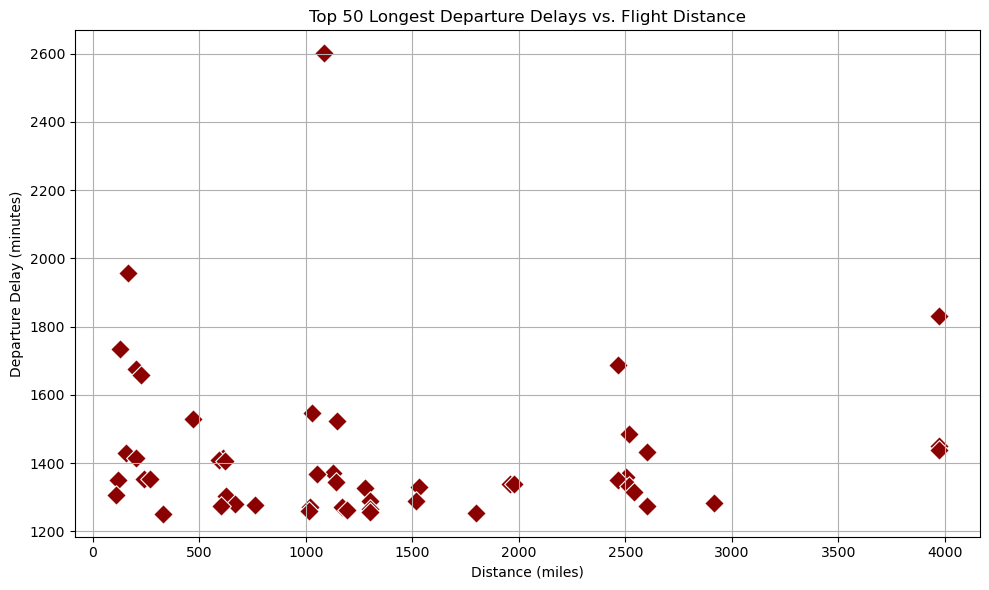

In [27]:
#Departure Delay vs. Flight Distance

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

# Run query
cursor.execute('''
SELECT 
  Distance,
  DepDelay
FROM flightss
WHERE DepDelay IS NOT NULL AND Distance IS NOT NULL
''')

# Load results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(rows, columns=[col.lower() for col in columns])  # lower-case for consistency

df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
df['depdelay'] = pd.to_numeric(df['depdelay'], errors='coerce')
df = df.dropna(subset=['distance', 'depdelay'])

# Step 2: Filter to top 50 delays
df_top50 = df.sort_values(by='depdelay', ascending=False).head(50)

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_top50, x='distance', y='depdelay', color='darkred', s=100, marker='D')
plt.title('Top 50 Longest Departure Delays vs. Flight Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Departure Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

**SHORT ROUTE, LONG DELAY**

delays compared to longer ones. Many of the worst delays occurred on flights under 1,300 miles, suggesting that short-haul operations may be more vulnerable to disruption due to tighter schedules and turnaround times.

## CANCELLATION ANALYSIS

### PRIMARY REASONS FOR FLIGHT CANCELLATION

A canceled flight is often worse than a delayed one—because when it’s canceled, hope is gone, and passengers may find themselves stranded in unfamiliar places with limited options.

For this analysis on the primary reasons for flight cancellations, we used the CancellationCode field from the 2007.csv dataset (table name: flightss), where:

- 'A' = Carrier

- 'B' = Weather

- 'C' = NAS (National Airspace System)

- 'D' = Security

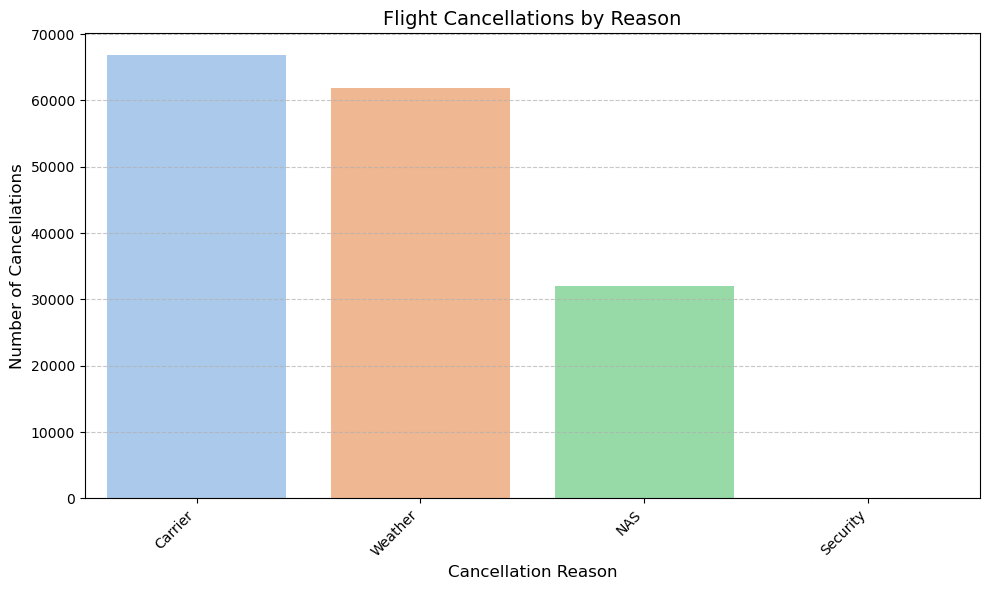

In [176]:
# Primary reasons for flight cancellation

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  CancellationCode AS reason_code,
  COUNT(*) AS cancellation_count
FROM flightss
WHERE Cancelled = 1
GROUP BY CancellationCode
ORDER BY cancellation_count DESC
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)
df.head()

# Map codes to reason names
reason_map = {
    'A': 'Carrier',
    'B': 'Weather',
    'C': 'NAS',
    'D': 'Security',
    '': 'Unknown'
}
df['Reason'] = df['reason_code'].map(reason_map)

df = df.sort_values(by='cancellation_count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))  # Increase the figure size to fit everything
sns.barplot(x='Reason', y='cancellation_count', data=df, hue='Reason', palette='pastel', dodge=False)
plt.title('Flight Cancellations by Reason', fontsize=14)
plt.xlabel('Cancellation Reason', fontsize=12)
plt.ylabel('Number of Cancellations', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

**CARRIER THE CULPRIT**

From the plot, we observe that the majority of flight cancellations in 2007 were caused by the carrier, accounting for over 60,000 cancellations.

This is followed by weather-related cancellations. Interestingly, while weather only contributed to 5.7% of departure delays, it often leads to complete service halts, making it a more severe disruption when it strikes. https://www.faa.gov/air_traffic/publications/media/2007_ATO_AR_9.pdf

### CANCELLATION RATE BY MONTH

For the analysis based on month, we used the month field from the 2007.csv dataset (table name: flightss).

This field allows us to explore trends in delays and cancellations across different times of the year, identifying weather patterns that may affect flight performance.

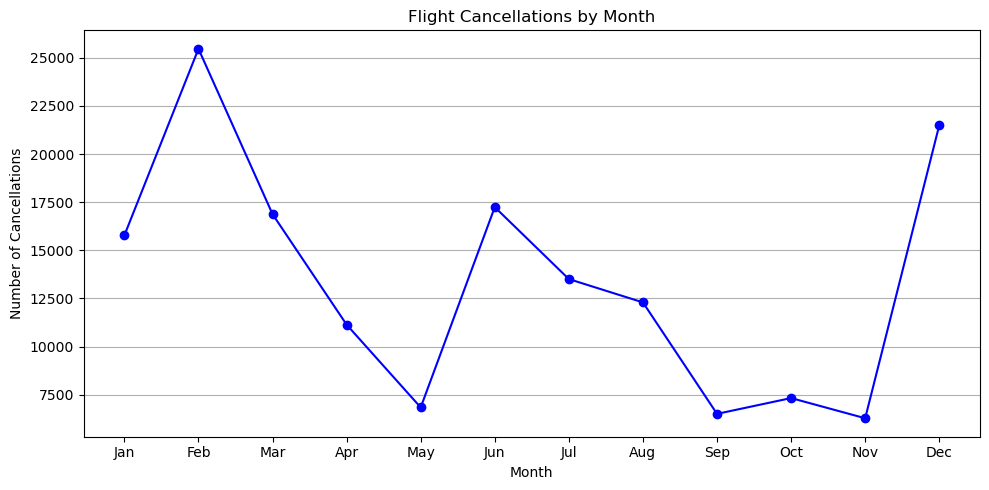

In [41]:
# Determine if cancellations correlate with specific airlines, airports, or time periods.
# Cancellation rate by month

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  Month,
  COUNT(*) AS cancelled_count
FROM flightss
WHERE Cancelled = 1
GROUP BY Month
ORDER BY Month
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

# Map month number to name
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['month_name'] = df['month'].astype(int).map(month_map)

# Ensure correct order
df['month_name'] = pd.Categorical(df['month_name'], categories=list(month_map.values()), ordered=True)
df = df.sort_values('month_name')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['month_name'], df['cancelled_count'], marker='o', linestyle='-', color='blue')
plt.title('Flight Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

**VALENTINE'S DAY**

From the plot, we observe that February recorded the highest number of cancellations, followed by December. This pattern aligns with severe winter weather events, such as the major snowstorm on February 13, 2007, which significantly disrupted air travel across the Midwest and Northeast.

According to the National Weather Service, the storm brought heavy snow, ice, and blizzard conditions, leading to widespread travel disruptions, including hundreds of flight cancellations and airport closures. This historic storm became known as the Valentine’s Day Blizzard. https://www.weather.gov/ilx/13feb07

**Heads-up Hotline**

Just like how delays are minimal, May and the autumn months (September to November) are the best times to fly, thanks to fewer cancellations, milder weather, and lighter travel traffic. If you're looking for smooth skies, this is your sweet spot.

### CANCELLATION BY AIRLINES

After identifying that the majority of cancellations were caused by carriers, a deeper analysis was performed to determine which airlines canceled the most flights.

This analysis uses fields from the 2007.csv dataset (table name: flightss):

- UniqueCarrier: Airline code

- Cancelled: Indicates whether a flight was canceled

And from the carriers.csv dataset (table name: carrierss):

- Code: Carrier code

- Description: Full airline name

These two tables were joined using the key: ON f.UniqueCarrier = c.Code

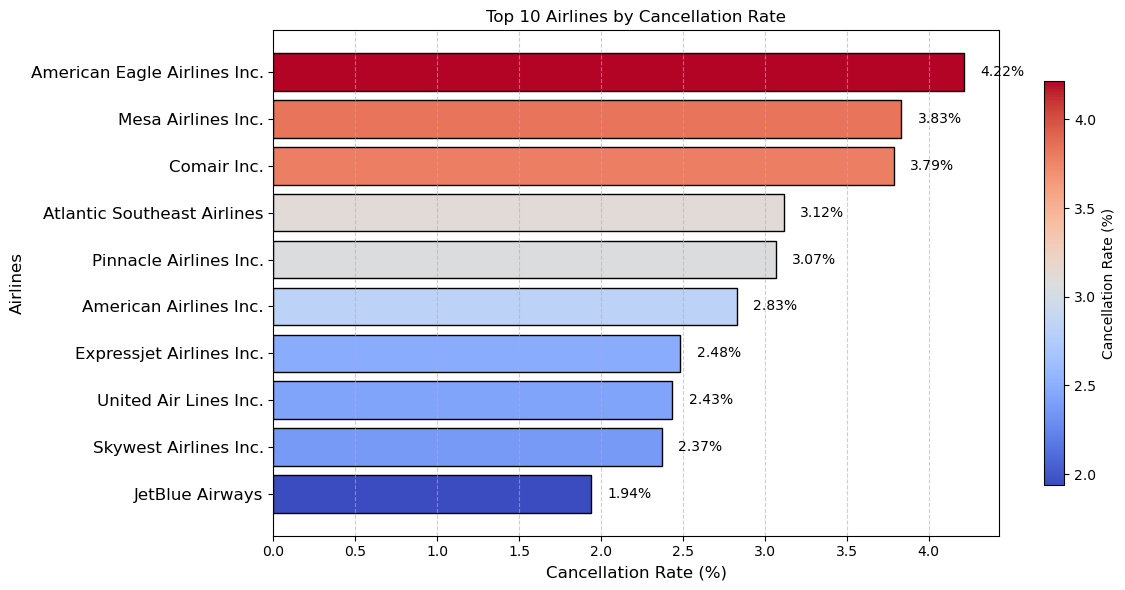

In [249]:
# Determine if cancellations correlate with specific airlines, airports, or time periods.
# Cancellation rate by airlines

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  f.UniqueCarrier,
  c.Description AS airline_name,
  COUNT(CASE WHEN f.Cancelled = 1 THEN 1 END) AS cancelled_flights,
  COUNT(*) AS total_flights,
  (COUNT(CASE WHEN f.Cancelled = 1 THEN 1 END) * 100.0 / COUNT(*)) AS cancellation_rate
FROM flightss f
JOIN carrierss c
  ON f.UniqueCarrier = c.Code
GROUP BY f.UniqueCarrier, c.Description
ORDER BY cancellation_rate DESC
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

# Convert cancellation_rate to float if it's not already
df['cancellation_rate'] = pd.to_numeric(df['cancellation_rate'], errors='coerce')

# Sort by cancellation rate and pick the top 10
df_sorted = df.sort_values(by='cancellation_rate', ascending=False).head(10)

# Create a color palette (e.g., using coolwarm colormap)
norm = plt.Normalize(df_sorted['cancellation_rate'].min(), df_sorted['cancellation_rate'].max())
cmap = plt.get_cmap('coolwarm')  # Change colormap if needed

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))  # Create figure and axis explicitly
bars = ax.barh(df_sorted['airline_name'], df_sorted['cancellation_rate'],
               color=cmap(norm(df_sorted['cancellation_rate'])), edgecolor='black')

# Title and labels
ax.set_title('Top 10 Airlines by Cancellation Rate')
ax.set_xlabel('Cancellation Rate (%)', fontsize=12)
ax.set_ylabel('Airlines', fontsize=12)

# Invert y-axis so the highest value is at the top
ax.invert_yaxis()

# Add gridlines to x-axis
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Add a colorbar to show the cancellation rate scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array to create colorbar
cbar = fig.colorbar(sm, ax=ax, label='Cancellation Rate (%)', shrink=0.8)

# Annotate bars with cancellation rate values
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
            f'{width:.2f}%', va='center', ha='left', color='black', fontsize=10)

# Tidy up layout for better presentation
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


**REGIONAL AIRLINES FLAWS**

From the plot, American Eagle Airlines Inc. had the highest cancellation rate at 4.22%. Mesa Airlines Inc., Comair Inc., Atlantic Southeast Airlines, and Pinnacle Airlines Inc., all are regional carriers, also recorded cancellation rates above 3%.

Regional airlines typically operate smaller aircraft in secondary markets to feed traffic into larger airline hubs. According to Yahoo News, these carriers face distinct challenges such as limited crew availability, tight turnaround schedules, and reduced operational flexibility, making them more vulnerable to cancellations—especially when disruptions occur within the hub-and-spoke system they rely on. https://www.yahoo.com/news/smaller-planes-big-questions-why-090149335.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAEbmmp8X9mOO_2A2_ZlqRNtkuvE_WGVAuBhDLc4dGAS-HTB2JyzAOxt7Z2YIHdkLTLSqIY0H06X7HFxUWsxe3Y6jqIIvzFw21986Suj8pF-KHh6JgcbFUJ8FvPSrX7kHtE1zw8-kvp8-cH9hPuyDvfod7dv3dIRTdlpbloLvEYgs

### CANCELLATION BY ORIGIN AIRPORT

To analyze cancellations by origin airport, we used the following fields:

From airport.csv (table name: airportss):

- airport: Full airport name

- city: City where the airport is located

- state: U.S. state of the airport

From 2007.csv (table name: flightss):

- Origin: Origin airport IATA code

- Cancelled: Indicates whether the flight was canceled

The two tables were joined using the key: ON f.Origin = a.iata


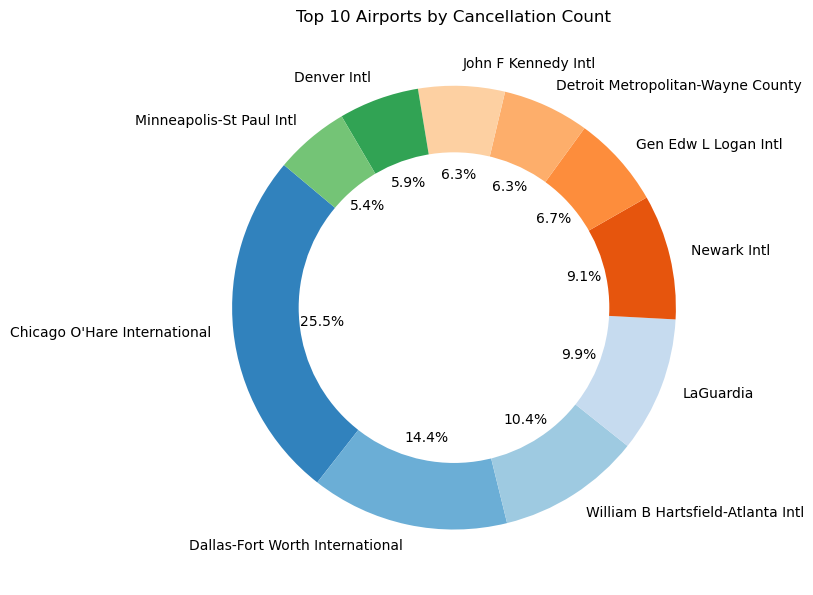

In [35]:
# Determine if cancellations correlate with specific airlines, airports, or time periods.
# Cancellation by origin airport 

cursor.execute("SET tez.runtime.io.sort.mb=128")
cursor.execute("SET hive.execution.engine=mr")  # or 'mr' if Tez keeps failing

cursor.execute('''
SELECT 
  a.airport AS origin_airport_name,
  a.city AS city,
  a.state AS state,
  COUNT(*) AS cancelled_count
FROM flightss f
JOIN airportss a
  ON f.Origin = a.iata
WHERE f.Cancelled = 1
GROUP BY a.airport, a.city, a.state
ORDER BY cancelled_count DESC
LIMIT 10
''')

# Fetch results
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]  # Extract column names
df = pd.DataFrame(rows, columns=columns)

# Optionally shorten labels for display
df['label'] = df['origin_airport_name'] + "\n(" + df['city'] + ", " + df['state'] + ")"

# Step 1: Limit to Top 10
df_top10 = df.sort_values(by='cancelled_count', ascending=False).head(10)

# Step 2: Create labels (airport only or add city/state if you want more context)
labels = df_top10['origin_airport_name']  # or: df_top10['city'] + ', ' + df_top10['state']

# Step 3: Create donut chart
plt.figure(figsize=(8, 8))
colors = plt.cm.tab20c.colors

plt.pie(df_top10['cancelled_count'], labels=labels,
        autopct='%1.1f%%', startangle=140, colors=colors)

# Donut style: add center circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Top 10 Airports by Cancellation Count')
plt.tight_layout()
plt.show()

**O'HARE = O'HERE**

From the plot, we can see that Chicago O’Hare International Airport recorded the highest percentage of cancellations, accounting for 25.5% of total cancellations among the top airports. It is followed by Dallas/Fort Worth International Airport at 14.4% and Hartsfield–Jackson Atlanta International Airport at 10.4%. These major hubs experience high traffic volumes, making them more vulnerable to widespread disruptions.

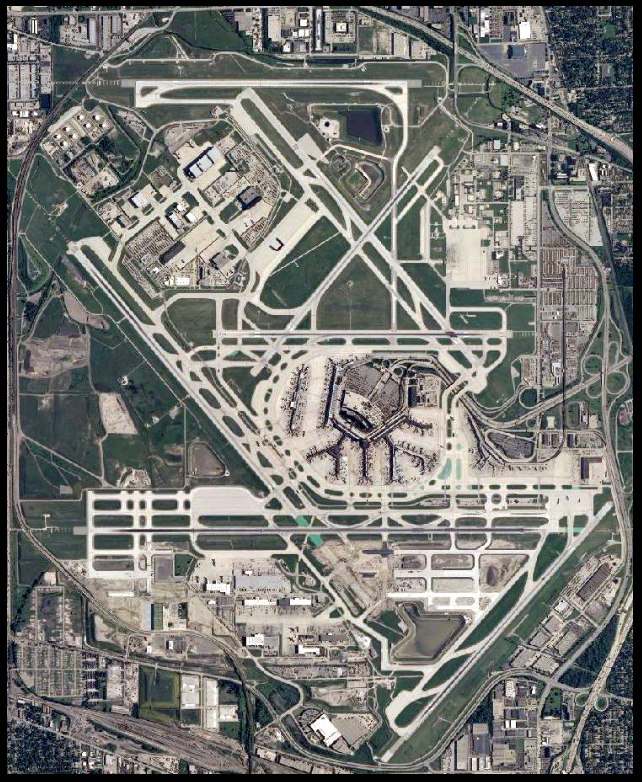

**CHICAGO O'HARE INTERNATIONAL AIRPORT (ORD)** Located approximately 17 miles northwest of downtown Chicago, O’Hare International Airport is one of the world’s busiest and most connected airports. Operated by the Chicago Department of Aviation, it covers 7,627 acres and offers non-stop flights to 249 destinations across six continents.

Midway was once famously called the "busiest square mile in the world" due to its limited size and high traffic. O’Hare was designed to handle greater capacity and introduced many airport innovations, including jet bridges, underground refueling systems, and direct highway access to terminals. Today, O’Hare remains a vital aviation hub and ranks as the fourth busiest airport in the world by aircraft movements. https://en.wikipedia.org/wiki/O'Hare_International_Airport

The O’Hare Modernization Program (OMP) began in 2005 and was completed in 2021. This large-scale initiative aimed to reconfigure runways, expand terminal capacity, and reduce delays at Chicago O’Hare International Airport. While it significantly improved long-term operational efficiency, various phases of construction also led to temporary gate shortages, airfield congestion, and increased operational delays during the transition period. https://www.iedconline.org/clientuploads/Economic%20Development%20Journal/EDJ_05_Spring_Airport_Modernization.pdf

### 2007 Airline Delays Second-Worst Ever

According to a 2008 CBS News report, airline delays in 2007 were the second-worst on record, with nearly 30% of all U.S. flights delayed, canceled, or diverted. The overall on-time performance dropped to 73.3%, the lowest since 2000. Major contributing factors included bad weather, air traffic control congestion, and airline scheduling issues. The situation was especially severe during the summer and holiday travel seasons, leading to a spike in passenger complaints. The report highlighted growing frustration among travelers and increasing concerns about the reliability and efficiency of the U.S. air travel system. https://www.cbsnews.com/news/2007-airline-delays-second-worst-ever/

## CONCLUSION

Despite 2007 being one of the worst years on record for airline delays, several key patterns emerged. Delays tend to build up toward the evening, often as a cascading effect from earlier flights. Winter weather brings unpredictability with snow, ice, and low visibility, while summer introduces its own share of storm-related delays.

The leading cause of delay is late-arriving aircraft, followed by carrier-related issues. Interestingly, shorter-distance routes are more prone to delays.So if you are heading off on a ski trip to Eagle County Regional Airport (EGE), don’t be surprised if you face a wait.

On the cancellation front, the main culprit is the carrier itself, one of older the reason is aircraft. Unpredictable winter weather also contributes to a significant number of cancellations. Regional airlines, operating with tight schedules and fewer resources, show a higher rate of cancellations. Meanwhile, major hub airports can leave travelers stranded for hours, as delays ripple through high-volume operations.